# Previous Reproduce
## Note:
- Using DIY trials rather than original trials
- Image: original object img, without resize and white background
- Tokenizer: with `<eos> <sos>` tokens
## Update: order correlation analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

def parse_results(files):
    overall_acc_dict = {}
    df_list = []  

    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            model_type = data['args']['model'] 

            if model_type not in overall_acc_dict:
                overall_acc_dict[model_type] = []
            overall_acc_dict[model_type].append(data['overall_accuracy'])

            if 'cvcl' in model_type: # only collect cvcl's class-wise accuracy
                temp_df = pd.DataFrame([
                    {'Category': category, 'Accuracy': accuracy, 'Seed': data['args']['seed']}
                    for category, accuracy in data['class_accuracy'].items()
                ])
                df_list.append(temp_df)

    df = pd.concat(df_list, ignore_index=True)
    df['Mean_Accuracy'] = df.groupby('Category')['Accuracy'].transform('mean')
    df = df.sort_values(by='Mean_Accuracy', ascending=False)


    overall_acc = {model_type: sum(acc_list) / len(acc_list) if acc_list else 0 for model_type, acc_list in overall_acc_dict.items()}

    return df, overall_acc

In [2]:
# grep clip&cvcl results
files = glob.glob('results/DIY_trial_repro/*.json')
df, overall_acc = parse_results(files)
print(df.head(10))
print(overall_acc)

    Category  Accuracy  Seed  Mean_Accuracy
28       dog  0.870588    43       0.832941
92       dog  0.835294    42       0.832941
284      dog  0.811765    39       0.832941
156      dog  0.788235    41       0.832941
220      dog  0.858824    40       0.832941
206    broom  0.858824    40       0.807059
78     broom  0.788235    42       0.807059
142    broom  0.788235    41       0.807059
270    broom  0.741176    39       0.807059
14     broom  0.858824    43       0.807059
{'clip': 0.993125, 'cvcl_res': 0.3675}


In [5]:
# function to draw fig.3A
import matplotlib.ticker as mtick

def plt_class_acc(df_class, overall_acc, split_index):
    categories = df_class['Category'].unique()
            
    dfs = [df_class[df_class['Category'].isin(categories[:split_index])], 
           df_class[df_class['Category'].isin(categories[split_index:])]]

    cvcl_key = next((k for k in overall_acc if 'cvcl' in k), None)
    clip_key = next((k for k in overall_acc if 'clip' in k), None)

    fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharey=True)
    # fig.suptitle('Repro Results Using Provided Trial File', fontsize=18)
    meanpointprops = dict(marker='o', markeredgecolor='gray', markerfacecolor='Black', markersize=2.5)

    for i, df_part in enumerate(dfs):
        sns.boxplot(x='Category', y='Accuracy', data=df_part, ax=axs[i], color='silver',
                    fliersize=0, linewidth=1.5, showmeans=True, meanprops=meanpointprops)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
        axs[i].set_ylabel('Accuracy (%)', fontsize=15)
        axs[i].set_xlabel('')
        axs[i].axhline(y=0.25, color='black', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc[cvcl_key], color='green', linestyle='--', linewidth=2.0)
        axs[i].axhline(y=overall_acc[clip_key], color='cornflowerblue', linestyle='--', linewidth=2.0)
        
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc[cvcl_key], f'CVCL {overall_acc[cvcl_key]*100:.2f}%',
                    color='green', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, overall_acc[clip_key], f'CLIP {overall_acc[clip_key]*100:.2f}%',
                    color='cornflowerblue', va='center', fontsize=12)
        axs[i].text(len(df_part['Category'].unique()) + 0.1, 0.25, f'Baseline 25.00%',
                    color='Black', va='center', fontsize=12)
        
        axs[i].grid(True, linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
        axs[i].set_ylim(0, 1.02)
        axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_95176/2352971033.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)
/tmp/ipykernel_95176/2352971033.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=35, ha='right', fontsize=11)


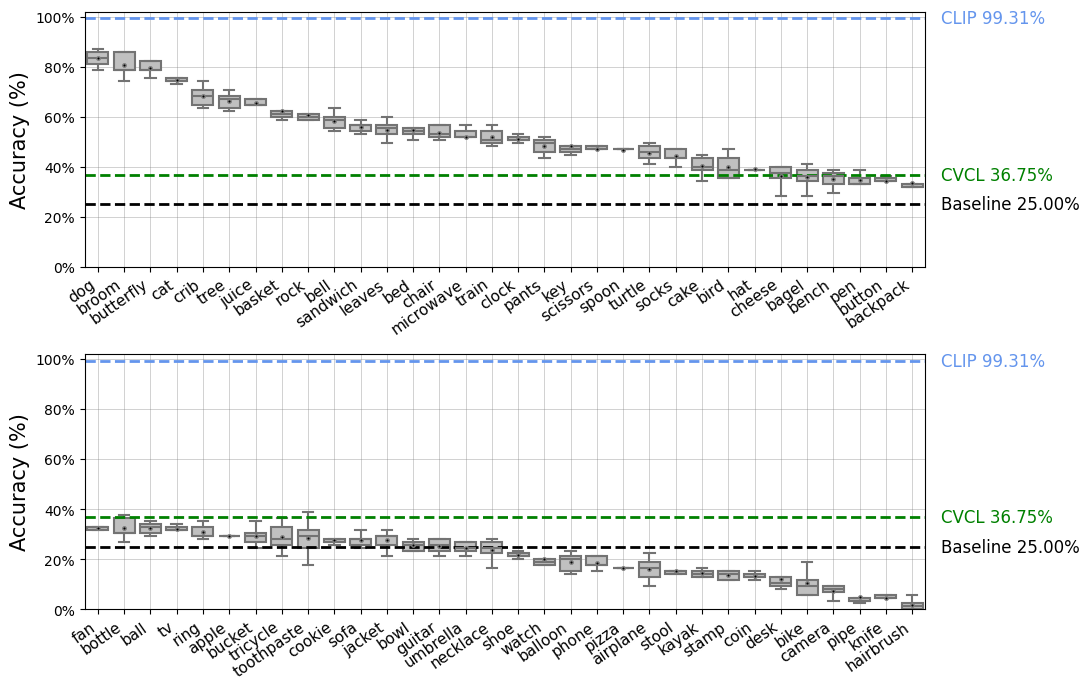

In [6]:
plt_class_acc(df, {k: np.mean(v) for k, v in overall_acc.items()}, len(df['Category'].unique()) // 2)

In [18]:
DIY_order = df.sort_values(by='Mean_Accuracy', ascending=False)['Category'].unique().tolist()

with open('results/reported_order.txt', 'r') as file: # derived from original results
    reported_order = [line.strip() for line in file.readlines()]

print(DIY_order[:6])
print(reported_order[:6])

['dog', 'broom', 'butterfly', 'cat', 'crib', 'tree']
['apple', 'crib', 'butterfly', 'juice', 'broom', 'hat']


## Order Correlation Analysis
1. Using Kendall's tau to measure the correlation between the order of reproduced results
2. Visualize using a heatmap-like plot, showing difference of order

In [23]:
# calculate Kendall's tau
from scipy.stats import kendalltau

def generate_rank_map(order_list):
    """Create a mapping from list items to their indices."""
    return {item: rank for rank, item in enumerate(order_list)}

def calculate_kendalls_tau(DIY_order, reported_order):
    """Calculate Kendall's tau between two orderings."""
    rank_map_DIY, rank_map_reported = generate_rank_map(DIY_order), generate_rank_map(reported_order)
    rank_DIY = [rank_map_DIY[item] for item in reported_order]
    # print(rank_DIY)
    rank_reported = [rank_map_reported[item] for item in reported_order]
    # print(rank_reported)

    tau, p_value_tau = kendalltau(rank_DIY, rank_reported)
    return tau, p_value_tau

rank_map_DIY, rank_map_reported = generate_rank_map(DIY_order), generate_rank_map(reported_order)
tau, p_value_tau = calculate_kendalls_tau(DIY_order, reported_order)
print("Kendall's tau:", tau, "p-value:", p_value_tau)

Kendall's tau: 0.5178571428571429 p-value: 1.4616292035429482e-09


## Visualize the order difference:
- Anchored on origianl(reported) order of object evaluation, x-axis is the original order
- The darker the blue, the more different order of this class
- E.g. “apple” is 1st in reported rank, but 38 ahead in our DIY reproduced rank


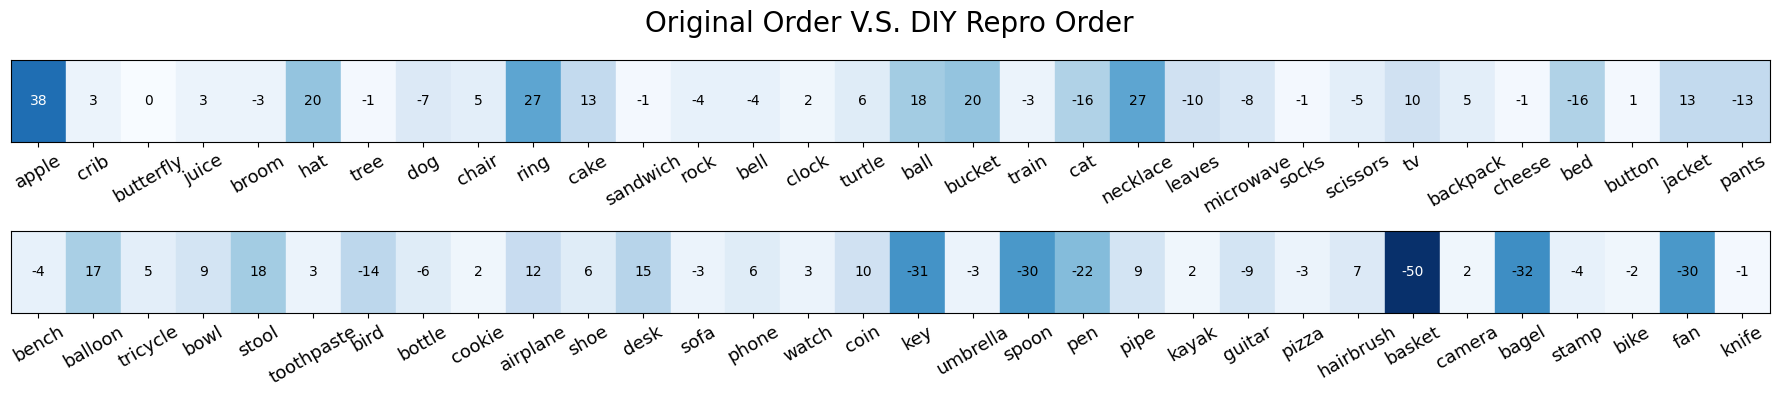

In [25]:
# calculate the difference between the two orders
differences = np.array([rank_map_DIY[item] - rank_map_reported[item] for item in reported_order])

abs_diff = np.abs(differences)
# seperate plot in 2 parts
mid_point = len(reported_order) // 2

# 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))  
fig.suptitle('Original Order V.S. DIY Repro Order', fontsize=20)

# color heatmap
cmap = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=min(abs_diff), vmax=max(abs_diff))

# first part
for i, value in enumerate(abs_diff[:mid_point]):
    color = cmap(norm(value))
    square = plt.Rectangle((i, 0), 1, 1, color=color)
    ax1.add_patch(square)
    # display the actual difference value as text
    text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
    ax1.text(i + 0.5, 0.5, differences[i], ha='center', va='center', color=text_color, fontsize=10)

ax1.set_xlim(0, mid_point)
ax1.set_ylim(0, 1)
ax1.set_xticks(np.arange(0.5, mid_point + 0.5, 1))
ax1.set_xticklabels(reported_order[:mid_point], rotation=30, fontsize=13)
ax1.set_yticks([])

# second part
for i, value in enumerate(abs_diff[mid_point:]):
    color = cmap(norm(value))
    square = plt.Rectangle((i, 0), 1, 1, color=color)
    ax2.add_patch(square)
    # display the actual difference value as text
    text_color = 'white' if np.mean(color[:3]) < 0.5 else 'black'
    ax2.text(i + 0.5, 0.5, differences[mid_point + i], ha='center', va='center', color=text_color, fontsize=10)

ax2.set_xlim(0, len(abs_diff) - mid_point)
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(0.5, len(abs_diff) - mid_point + 0.5, 1))
ax2.set_xticklabels(reported_order[mid_point:], rotation=30, fontsize=13)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

### Fig.3.B Generalization Example Scores
Run following cells, they are doing:
1. Get trials containing example images.
2. Perform zero-shot evaluation on the example images.
3. Average the accuracy of the example images.(each img has 5 trials)

You may need to modify path of trial files

In [ ]:
import json
seeds = [39, 40, 41, 42, 43]

def get_gen_trials(seed):
    images_txt_path = 'trials/fig_3b.txt' 
    json_file_path = f'trials/object_{seed}.json'
    output_json_path = f'trials/fig_3b_{seed}.json'

    with open(images_txt_path, 'r') as file:
        images = [line.strip() for line in file]

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    filtered_data = []
    image_counters = {}
    category_counter = 1  

    for image_path in images:
        if image_path not in image_counters: 
            image_counters[image_path] = category_counter
            category_counter += 1 

        for item in data:
            if item["target_img_filename"] == image_path:
                new_item = item.copy()
                category_prefix = new_item["target_category"].rstrip('0123456789') 
                new_item["target_category"] = f"{category_prefix}{image_counters[image_path]}"
                filtered_data.append(new_item)

    with open(output_json_path, 'w') as file:
        json.dump(filtered_data, file, indent=4)
    
    return output_json_path

In [ ]:
# run zs prediction on filtered json
from torch.utils.data import DataLoader
import torch
from data_utils import get_model, get_dataset
from utils import set_seed
from models.zs_trial_predic import ZSTrialClassifier

def main_zs(seed, json_path):
    set_seed(seed)
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    trial_path = json_path
        
    model_name = 'cvcl_res'
    model, transform = get_model(model_name, device)    
    data = get_dataset(dataset_name='object-trial', transform=transform, trials_file=trial_path)
    dataloader = DataLoader(data, batch_size=64, shuffle=False, num_workers=4)

    classifier = ZSTrialClassifier(model_name, model, device)

    acc, cls_acc = classifier.predict(dataloader=dataloader)

    # results = save_trial_results(args_dict=None, accuracy=acc, cls_accuracy=cls_acc)
    
    return cls_acc  

In [ ]:
from collections import defaultdict
# loop all seeds
all_class_accuracies = defaultdict(list)
for seed in seeds:
    json_path = get_gen_trials(seed)
    cls_acc = main_zs(seed, json_path)


    for class_name, accuracy in cls_acc.items():
        all_class_accuracies[class_name].append(accuracy)

avg_class_acc = {class_name: sum(acc_list) / len(acc_list) 
                            for class_name, acc_list in all_class_accuracies.items()}

Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:16<00:00,  8.42s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:10<00:00,  5.47s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:13<00:00,  6.98s/it]


Loading CVCL...


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


Successfully loaded CVCL-resnext50
Loading dataset: object-trial


Evaluating: 100%|██████████| 2/2 [00:12<00:00,  6.02s/it]


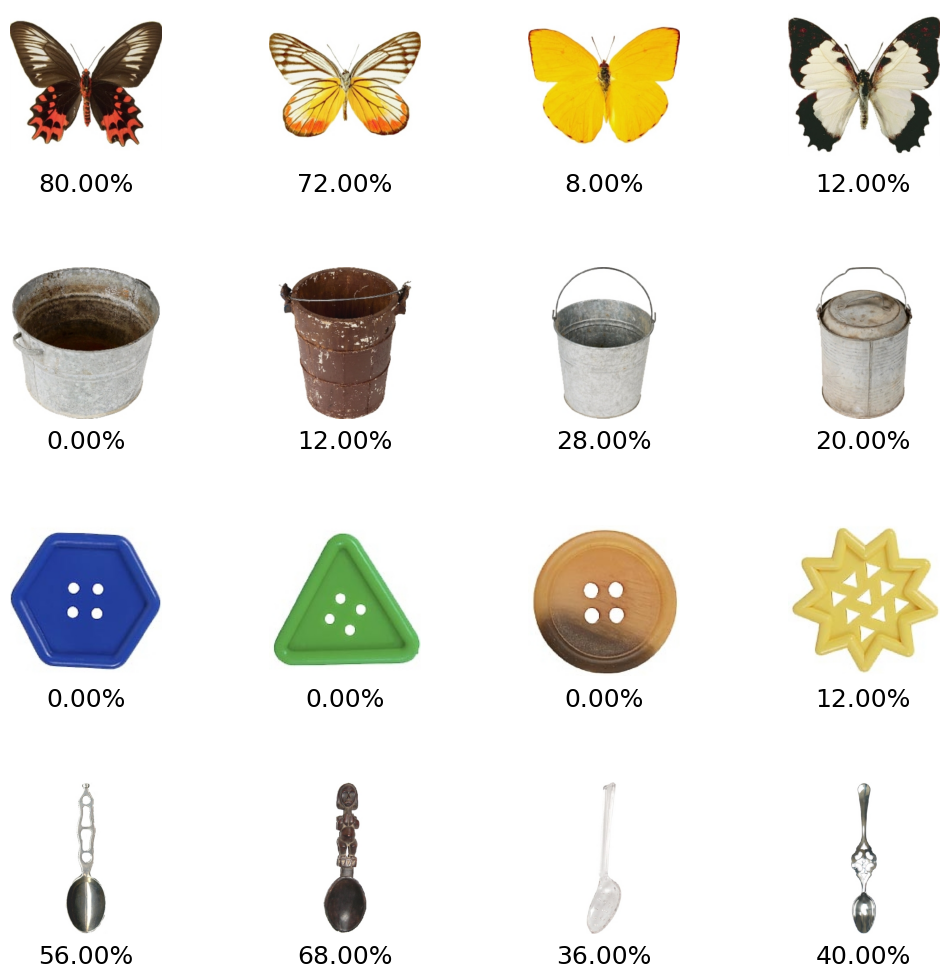

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# get scores avg 5 trials
# load image 
with open(f'datasets/trials/gen_example_{seeds[0]}.json', 'r') as file:  
    image_data = json.load(file)
    image_filenames = {entry['target_category']: entry['target_img_filename'] for entry in image_data}

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, (class_name, avg_accuracy) in enumerate(avg_class_acc.items()):
    img_path = image_filenames[class_name]
    if not img_path.startswith('/'):  
        img_path = f'datasets/trials/{img_path}'  
    img = plt.imread(img_path)  
    
    axes[i].imshow(img, extent=[0.3, 0.7, 0.3, 0.7])
    # axes[i].set_title(f'{avg_accuracy * 100:.2f}%', fontsize=18)
    axes[i].axis('off')
    axes[i].text(0.5, -0.2, f'{avg_accuracy * 100:.2f}%', fontsize=18, ha='center', transform=axes[i].transAxes)

    # rect = Rectangle((0, 0), 1, 1, transform=axes[i].transAxes,
    #                  linewidth=2, edgecolor='black', facecolor='none')
    # axes[i].add_patch(rect)

plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.show()